# Possible substrates and their potential
This script evaluates the model medium and other carbon sources for the production of malonic acid in K. phaffii. For this the minimal medium and the conclusions for the model organism are discussed. Afterwards an in deth analysis of the possibilites for oher substrates than methanol is conducted. There the behaviour for biomass growth, malonic acid and a combination through a constrained optimization is simulated and analyzed.

In [1]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt
model = read_sbml_model('../src/models/gen/iMT1026-v3.1.xml')
%run -i create_pathway.ipynb
# flux unit is mmol / [gDW h]

In [2]:
# path_selector legend
# 0 -> no additional reactions
#1 -> beta alanine pathway  
#2 -> transferase malonyl-CoA pathway  
#3 -> oxidoreuctive malonyl-CoA pathway
#4 -> lactate pathway  
#create_pathway(model,3)  # self-built function create_pathway(model, path_selector), that adds pathway
beta_model = create_pathway(model.copy(),1)
trn_malonyl_model = create_pathway(model.copy(),2)
red_malonyl_model = create_pathway(model.copy(),3)
lactate_model = create_pathway(model.copy(),4)
models = [(beta_model,'Beta-Alanine'),(trn_malonyl_model,'Malonyl-CoA Transferase'),(red_malonyl_model,'Malonyl-CoA Oxidored'),(lactate_model,'Lactate')]

Added beta alanine pathway
Added trans malonyl-CoA pathway
Added red malonyl-CoA pathway
Added lactate pathway


# Evaluating for minimal medium
In this section the minimal fluxes to achieve the specified growth or malonic acid production are obtained.  This way the medium is analysed for essential components and their quantative uptake, in order to identify possible limiting factors.

In [3]:
from cobra.medium import minimal_medium
# General medium for all models based on the unchanged vanilla model (=same medium as in all derived models)
medium = model.medium
medium['Ex_meoh'] = 6  # Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium['Ex_glyc'] = 0  # shutting down glycerol as a substrate
print(medium)

{'Ex_h2o': 1000.0, 'Ex_nh4': 1000.0, 'Ex_pi': 1000.0, 'Ex_h': 1000.0, 'Ex_o2': 1000.0, 'Ex_so4': 1000.0, 'Ex_glyc': 0, 'Ex_fe2': 1000.0, 'Ex_btn': 4e-05, 'Ex_k': 1000.0, 'Ex_meoh': 6}


### Analyzing for biomass growth and  malonic acid production
The medium is anaylsed for essential components for biomass growth and production of malonic acid..

In [4]:
# for biomass growth
df_med_bio = pd.DataFrame()   # creating data frame for better visualization

for pairing in models[:2]:   # only looking at the first two pathways (see pathway_evaluations)
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium  # setting medium for model
        max_growth = pathway_model.slim_optimize()
        min_med=minimal_medium(pathway_model, max_growth)  # evaluating the minimal medium to achive the biomass growth in the model
        min_med['biomass growth'] = max_growth  # saving the growth in the same data series
        df_med_bio[pairing[1]+' bio'] = min_med   # saving the generated result in the data frame under the pathway name

In [5]:
# for malonic acid production growth
df_med_mln = pd.DataFrame()

for pairing in models[:2]:  # only looking at the first two pathways (see pathway_evaluations)
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        max_production = pathway_model.slim_optimize()
        min_med = minimal_medium(pathway_model, max_production)
        min_med['MA production'] = max_production
        df_med_mln[pairing[1]+' MA'] = min_med

### Results
The computed minimal medium composition and fluxes are compared against each other and graphically displayed.

,Ex_nh4,Ex_pi,Ex_o2,Ex_so4,Ex_meoh,biomass growth,MA production
Beta-Alanine bio,0.590011,0.023928,5.623948,0.004172,6.0,0.095112,NaN
Malonyl-CoA Transferase bio,0.590012,0.023928,5.623949,0.004172,6.0,0.095112,NaN
Beta-Alanine MA,NaN,NaN,5.000000,NaN,6.0,NaN,2.0
Malonyl-CoA Transferase MA,NaN,NaN,5.000000,NaN,6.0,NaN,2.0


<AxesSubplot:>

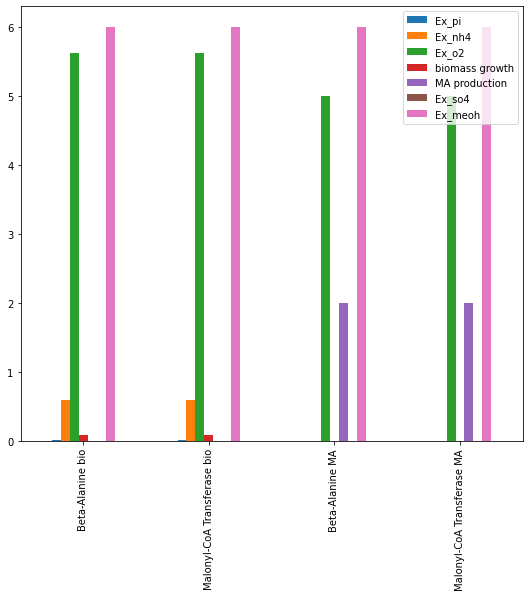

In [6]:
transpose=pd.concat([df_med_bio.T, df_med_mln.T])  # creating a single df for both evaluations, where the constituents are described through the columns
display(transpose)
arguments = list(set(list(df_med_bio.index) + list(df_med_mln.index)))  # creating a list of the displayed pathways to hand it to the figure
transpose.plot(y= arguments, kind='bar', figsize=(9,8))

### Discussion
As seen in the results, the medium only needs a few components to ensure the growth and production. In general the substrate is the limitation in both cases. Further it has to be noticed, that the demands to the medium are much lower for the malonic acid production, which theoretically only needs the carbon source and oxygen to work.  
Nevertheless, it has to be noted, that several compounds are deemed as unnecessary which has to be seen critical. First and foremost the complex additive Biotin doesnt seem to effect the growth or malic acid production in any way, while it is known to be vital to yeast organisms.

## Evaluating other carbon sources
To further explore the potential of the cellfactory, all possible carbon sources are investigated and the obtained maximum fluxes are compared. An in depth analysis can be found in [substrate_alternatives](https://github.com/27410/group-assignment-2021-group-8-malonic-acid-in-k-phaffii/blob/main/scripts/Substrate_alternatives.ipynb). Here, only the malonic acid production with a growth constraint is discussed. Results are normalized by setting up the media with the same cmol based substrate flux.

### Objective MA production
The carbon sources are evaluated for their malonic acid production potential

In [7]:
# Determining the implemented exchange reactions in the model
exchange_reactions =[]
for reaction in model.exchanges:  # getting all the Ex_ reactions implemented in the model
        metabolites = reaction.metabolites.keys()   # listing all the metabolites in those reactions -> only one since it is an Ex_ reaction, trick to access the metabolites
        for ids in metabolites:  # for loop so the id can be can be accessed instead of the dict object tha the .keys function yields, because only one metabolite can be in here this for loop only finishes after one pass
            if model.metabolites.get_by_id(str(ids)).formula == None:  # when the exchanged metabolite has no chemical formula it is passed on
                pass
            elif 'C' in model.metabolites.get_by_id(str(ids)).formula: # if the exchanged metabolites contains carbon it is added to the list of carbon sources
                exchange_reactions.append(reaction.id)
                break  # redundent with the assumption that each exchange reaction only contains one metabolite

In [8]:
# Helper function to count the C-Atoms within the metabolite to evaluate C-maol based results later
def count_C(pathway_model,metabolite):
    # counts the C in the metabolite formula -> returns the number formated as an float
    C_locator = pathway_model.metabolites.get_by_id(str(metabolite)).formula.find('C')+1  # locator gives back the position of the C to access the number after it in the formula = amount of carbon in one molecule
    H_locator = pathway_model.metabolites.get_by_id(str(metabolite)).formula.find('H')  # usually the element mentioned after the C so c amount is inbetween C and H in the formula
    C_amount = pathway_model.metabolites.get_by_id(str(metabolite)).formula[C_locator:H_locator]
    if C_amount == '':  # in case there is only one C, the number is not written and the locators will return an empty string that is caught here
        C_amount = '1'
    elif 'O' in C_amount: # with this CO2 is caught
        C_amount = '1'
    return float(C_amount)

In [9]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
substrate_table = pd.DataFrame()  # the final data frame that is filled with all the possible substrates and their flux for wvery pathway
ex_subs = []
for pairing in models:  # evaluates for all handed models
    pathway_model = pairing[0]  # chooses the model variable out of the tuple (model,name of model)
    poss_subs = dict()  # dictionary that will be filled with substrate = objective value
    not_poss = []  # additionally collected list of substrate that dont result in groth or production, is not used further in the analysis
    for sub in exchange_reactions:  # loops over all the obtained carbon source exchange reactions
        with pathway_model:  # only manipulate the model in an enclosed environment
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()  # obtain the metabolites (see exchange reactions)
            for met in meta:  # to access the metabolite identifier
                C_amount = count_C(pathway_model,met)  # gather the amount of carbons in the metabolite
            #set up medium
            medium = pathway_model.medium  # get medium
            medium['Ex_glyc']= 0  # set default substrate to zero
            medium[sub]= 10/C_amount  # for Cmol based evaluation, in order to have a 10 C-mmol supply flux for every carbon source
            pathway_model.medium = medium  # hand new medium definition to model
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')  # set the bjective of the siulation to malonic acid production
            ma_prod_sub = pathway_model.slim_optimize(error_value=0.)  # safe the maximum flux in a variable (error_value neglects flux below 0.)
            # analyse
            if ma_prod_sub > 0:  # add the substrate with its flux to a dictionary if it produces malonic acid
                poss_subs[met.name] = round(ma_prod_sub, 2)
                ex_subs.append(sub)
            else:  # save it in a different list when it doesnt produce anything
                not_poss.append(sub)
    name = pairing[1]   # at the end of the simulation of one pathway, the obtained dictionary for substrates that produce malonic acid is saed under the pathway name in a gathering data frame defined at the beginning
    substrate_table[name] = pd.Series(poss_subs)

In [10]:
# code to include the stochimetric fomrula of every metabolite into the data frame
all_subs_formula = dict()  # dictionary that will contain all the metabolites of the exchange reaction as reaction id : formula
all_subs_id = dict()
for sub in exchange_reactions:  # loops over every substrate in the exchange reaction
    meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()  # access the metabolite
    for met in meta:  # acess the metabolite id
        all_subs_formula[met.name] = pathway_model.metabolites.get_by_id(str(met)).formula  # assign the metabolite identifier its formula in the model
# Sorting out all the metabolites that dont show growth
poss_subs_formula = dict()
for poss_meta in poss_subs:  # only adding the metabolites formula contained in the data frame
    poss_subs_formula[poss_meta] = all_subs_formula[poss_meta]

substrate_table['Formula'] = pd.Series(poss_subs_formula) # adding the obatained dictionary to the data frame

In [11]:
# Sorting the data frame by the values of beta alanine first and then lactate and retrieving the table 
substrate_table.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate,Formula
Trehalose,3.33,3.33,3.33,3.33,C12H22O11
D-Glucose,3.33,3.33,3.33,3.33,C6H12O6
"1,3-beta-D-Glucan",3.33,3.33,3.33,3.33,(C6H10O5)n
Glycerol,3.33,3.33,3.33,3.33,C3H8O3
D-Sorbitol,3.33,3.33,3.33,3.33,C6H14O6
D-Mannitol,3.33,3.33,3.33,3.33,C6H14O6
D-Fructose,3.33,3.33,3.33,3.33,C6H12O6
D-Mannose,3.33,3.33,3.33,3.33,C6H12O6
Xylitol,3.33,3.33,3.33,3.33,C5H12O5
D-Xylose,3.33,3.33,3.33,3.27,C5H10O5


<AxesSubplot:title={'center':'MA production with different substrates'}, ylabel='C-mol based flux in mmol MA / (gDW*h)'>

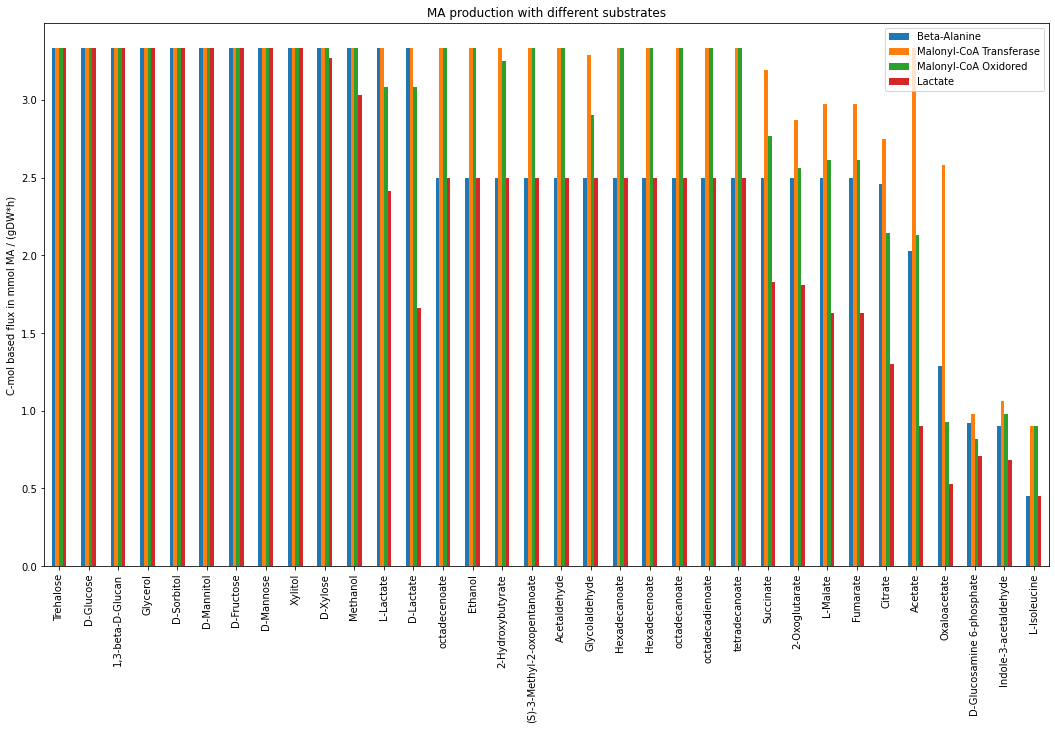

In [12]:
# creating the plot
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']   # defining the arguments that shall be plotted in the bar graph (all columns except the formula)
substrate_table.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'C-mol based flux in mmol MA / (gDW*h)', title = 'MA production with different substrates')

### Objective biomass growth
The carbon sources are evaluated for their capabilities to grow biomass.

In [13]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
# same code as for malonic acid production, but with different model objective, only changed line is annotated
substrate_table_bm = pd.DataFrame()
for pairing in models:
    pathway_model = pairing[0]
    poss_subs = dict()
    not_poss = []
    for sub in ex_subs:
        with pathway_model:
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
            for met in meta:
                C_amount = count_C(pathway_model,met)
            #set up medium
            medium = pathway_model.medium
            medium['Ex_glyc']= 0
            medium[sub]= 10/C_amount
            pathway_model.medium = medium
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_biomass')  # the model objective is changed for biomass growth
            biomass_prod = pathway_model.slim_optimize(error_value=0.)
            # analyse
            if biomass_prod > 0:
                poss_subs[met.name] = round(biomass_prod, 4)
            else:
                not_poss.append(sub)
    name = pairing[1]
    substrate_table_bm[name] = pd.Series(poss_subs)

In [14]:
# code to include the stochimetric fomrula of every metabolite into the data frame
all_subs_formula = dict()  # dictionary that will contain all the metabolites of the exchange reaction as reaction id : formula
all_subs_id = dict()
for sub in exchange_reactions:  # loops over every substrate in the exchange reaction
    meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()  # access the metabolite
    for met in meta:  # acess the metabolite id
        all_subs_formula[met.name] = pathway_model.metabolites.get_by_id(str(met)).formula  # assign the metabolite identifier its formula in the model
# Sorting out all the metabolites that dont show growth
poss_subs_formula = dict()
for poss_meta in poss_subs:  # only adding the metabolites formula contained in the data frame
    poss_subs_formula[poss_meta] = all_subs_formula[poss_meta]

substrate_table['Formula'] = pd.Series(poss_subs_formula) # adding the obatained dictionary to the data frame

In [15]:
# Sorting the data frame and retrieving the table 
substrate_table_bm.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table_bm

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate
Ethanol,0.2206,0.2206,0.2206,0.2206
Glycerol,0.2170,0.2170,0.2170,0.2170
Xylitol,0.2058,0.2058,0.2058,0.2058
D-Sorbitol,0.2027,0.2027,0.2027,0.2027
D-Mannitol,0.2027,0.2027,0.2027,0.2027
octadecanoate,0.2027,0.2027,0.2027,0.2027
Hexadecanoate,0.2018,0.2018,0.2018,0.2018
tetradecanoate,0.2005,0.2005,0.2005,0.2005
octadecenoate,0.1986,0.1986,0.1986,0.1986
octadecadienoate,0.1982,0.1982,0.1982,0.1982


<AxesSubplot:title={'center':'Biomass growth with different substrates'}, ylabel='Cmol based flux in mmol bm / (gDW*h)'>

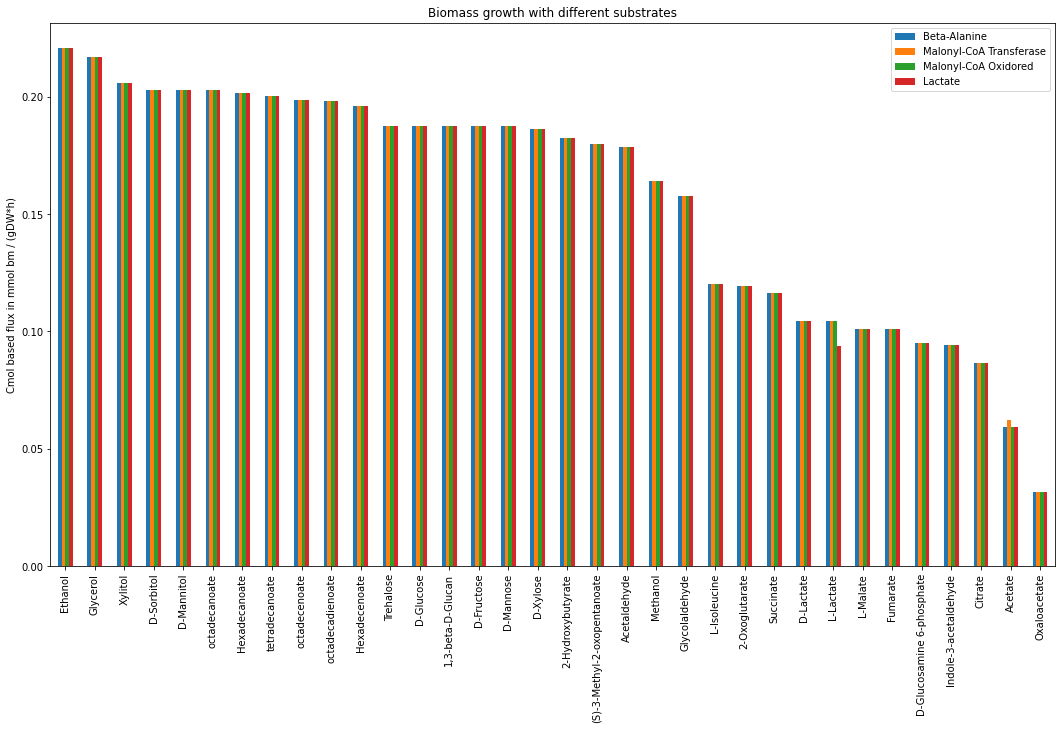

In [16]:
# creating the plot
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']
substrate_table_bm.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'Cmol based flux in mmol bm / (gDW*h)', title = 'Biomass growth with different substrates')

### Objective Ma production with constrained gowth at 50%
Finally, a combination of the both is evaluated, where the model objective is the malonic acid producation, but with a forced growth rate of half the maximum possible growth rate with the respective substrate.

In [17]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
factor_growth = 0.5  # growth factor is needed for the constraint, can be chosen as anything between 0 and 1
substrate_table = pd.DataFrame()
# ex_subs = []
for pairing in models:
    pathway_model = pairing[0]
    poss_subs = dict()
    not_poss = []
    for sub in exchange_reactions:
        with pathway_model:
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
            for met in meta:
                C_amount = count_C(pathway_model,met)
            #set up medium
            medium = pathway_model.medium
            medium['Ex_glyc']= 0
            medium[sub]= 10/C_amount  # for Cmol based evaluation, in order to have a 100 C-mmol supply flux
            pathway_model.medium = medium
            # Adding constraint
            max_growth_sub = pathway_model.slim_optimize(error_value=0.)  # evaluating the maximum growth rate for the current substrate the constraint
            constrained_growth = pathway_model.problem.Constraint(
                pathway_model.reactions.Ex_biomass.flux_expression,
                lb=max_growth_sub*factor_growth)  # the biomass flux gets a new minimum bound that is calculated by multiplying the obtained maximum growth with the set growth factor
            pathway_model.add_cons_vars(constrained_growth)  # constraint is added
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')  # simulate with the objective for malonic acid (while constraint is iin place)
            ma_prod_sub = pathway_model.slim_optimize(error_value=0.)  # saving the maximum flux under the set constraint
            # analyse
            if ma_prod_sub > 0:
                poss_subs[met.name] = round(ma_prod_sub, 2)
                #ex_subs.append(sub)
            else:
                not_poss.append(sub)
    name = pairing[1]
    substrate_table[name] = pd.Series(poss_subs)

In [18]:
# code to include the stochimetric fomrula of every metabolite into the data frame, same code as before, but has to be included since it can not be assumed that the same substrates as before resulted in production
all_subs_formula = dict()
all_subs_id = dict()
for sub in exchange_reactions:
    meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
    for met in meta:
        all_subs_formula[met.name] = pathway_model.metabolites.get_by_id(str(met)).formula
# Sorting out all the metabolites that dont show growth
poss_subs_formula = dict()
for poss_meta in poss_subs:
    poss_subs_formula[poss_meta] = all_subs_formula[poss_meta]

substrate_table['Formula'] = pd.Series(poss_subs_formula)

In [19]:
# Sorting the data frame and retrieving the table 
substrate_table.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate,Formula
Trehalose,2.21,2.24,1.96,1.78,C12H22O11
D-Glucose,2.21,2.24,1.96,1.78,C6H12O6
"1,3-beta-D-Glucan",2.21,2.24,1.96,1.78,(C6H10O5)n
D-Fructose,2.21,2.24,1.96,1.78,C6H12O6
D-Mannose,2.21,2.24,1.96,1.78,C6H12O6
D-Sorbitol,2.15,2.15,2.06,1.86,C6H14O6
D-Mannitol,2.15,2.15,2.06,1.86,C6H14O6
Xylitol,2.13,2.13,2.08,1.88,C5H12O5
D-Xylose,2.12,2.24,1.88,1.69,C5H10O5
Glycerol,2.07,2.07,2.07,2.06,C3H8O3


<AxesSubplot:title={'center':'MA production with different substrates at 50% growth'}, ylabel='C-mol based flux in mmol MA / (gDW*h)'>

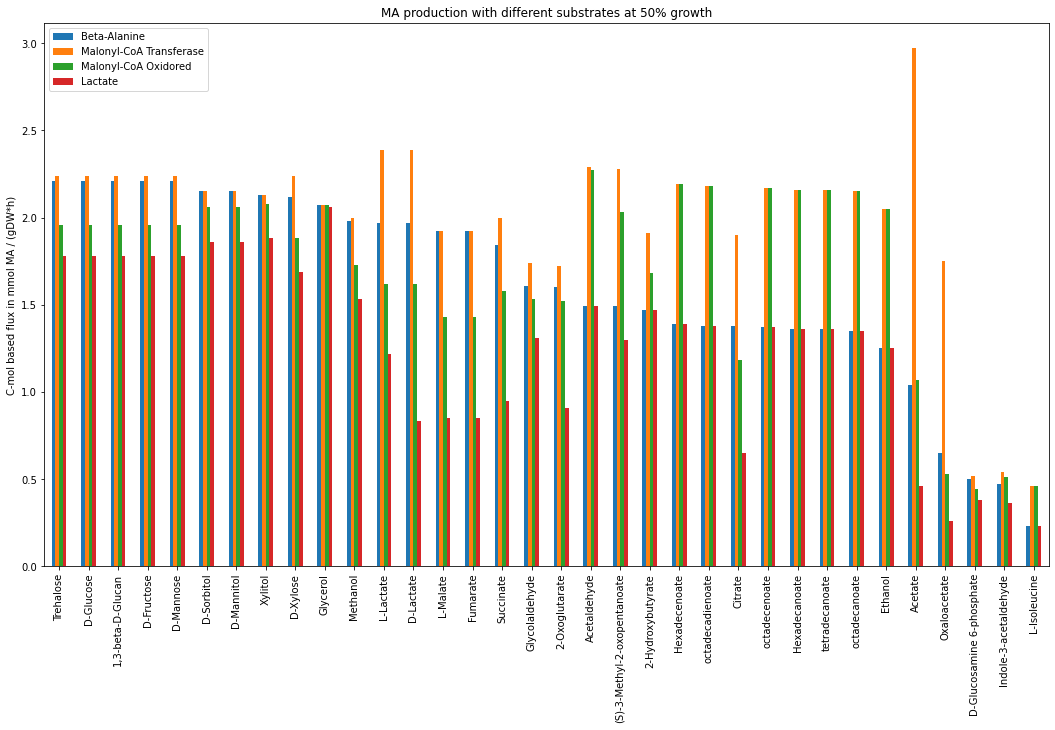

In [20]:
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']
substrate_table.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'C-mol based flux in mmol MA / (gDW*h)', title = 'MA production with different substrates at 50% growth')
# plt.savefig('../img/substrates_ma_cons.png')

### Discussion
Several substrates show better growth and production performance than methanol, which can be explained by the chemical energy contained in these substrates or the location where they enter the carbon metabolism. Also a superiority of the beta-alanine and the malonyl-coa transferase pathway can be observed. Clearly production and  growth can be increased by switching to a different substrate. But nonetheless methanol remains a good target, being a metabolite situated in the midfield, because it poses several advantages. First off, it doesn't create competition with the food industry and is a cheap substrate to obtain.  
  
The charateristic methanol inducible promoters of *K. phaffii* also give rise to the possibility of a two stage process (Miao 2021). A substrate that enables fast growth could be used to achieve a high cell density in the fermentation and then a switch to methanol triggers the metabolicly engineered cells to promote malonic acid production. This combination could result in an effetive way to produce malonic acid at space-time yields in our model organism.